Mercari Interactive EDA + Topic Modeling

https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show ,output_notebook

In [2]:
#教師データと検証データのインポート
#データサイズが大きいので、データ型を事前に指定した。
    dtype = {'train_id':'int32','name':'object','item_condition_id':'int8','category_name':'object','brand_name':'object',
             'price':'float32','shipping':'int8','item_description':'object'}
#パソコンの能力が低すぎるので1万データでお勉強しまそ
train = pd.read_csv('/home/kyohei/.kaggle/competitions/mercari-price-suggestion-challenge/train.tsv',sep='\t',dtype=dtype,nrows=10000)
test = pd.read_csv('/home/kyohei/.kaggle/competitions/mercari-price-suggestion-challenge/test.tsv',sep='\t',dtype=dtype,nrows=10000)

In [3]:
print(train.shape)
print(test.shape)

(10000, 8)
(10000, 7)


In [4]:
train.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...  
3         1  New with tags. Leather horses. Retail for [rm]...  
4         0          Complete with certificate of authenticity

In [5]:
#分布は0付近に偏ります
train.price.describe()

count    10000.000000
mean        26.429899
std         39.385696
min          0.000000
25%         10.000000
50%         16.000000
75%         29.000000
max       1506.000000
Name: price, dtype: float64

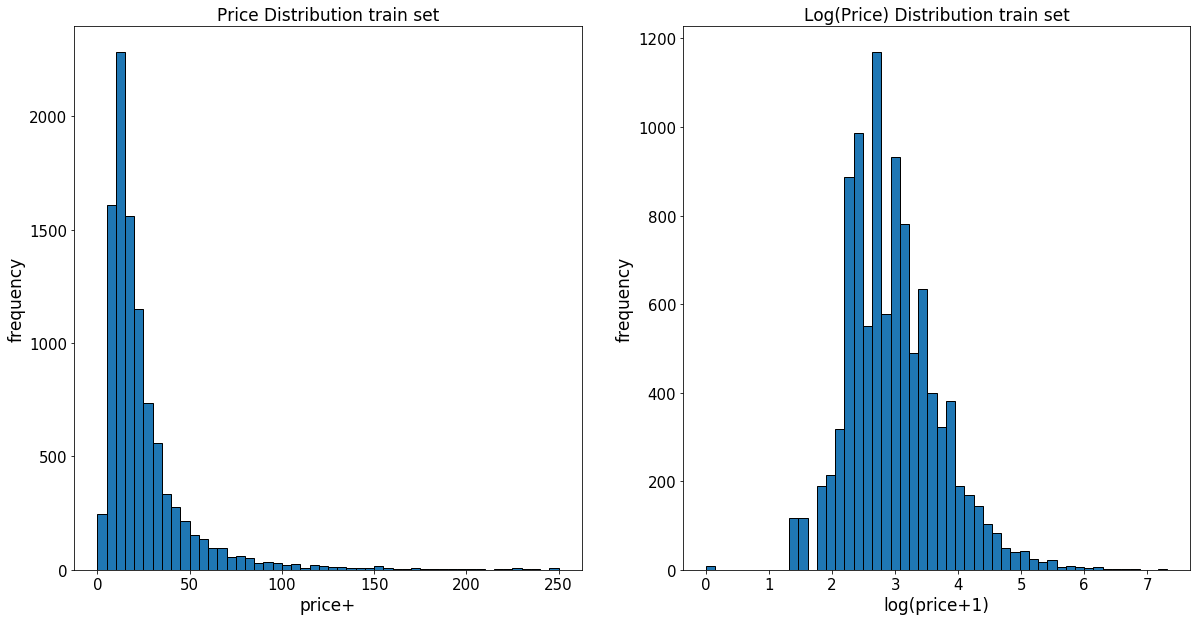

In [6]:
fig,axes = plt.subplots(1,2,figsize=(20,10))
train.price.plot(kind='hist',bins=50,edgecolor='black',range=[0,250],ax=axes[0])
axes[0].set_xlabel('price+',fontsize=17)
axes[0].set_ylabel('frequency',fontsize=17)
axes[0].tick_params(labelsize=15)
axes[0].set_title('Price Distribution train set',fontsize=17)

np.log(train.price+1).plot(kind='hist',bins=50,edgecolor='black',ax=axes[1])
axes[1].set_xlabel('log(price+1)',fontsize=17)
axes[1].set_ylabel('frequency',fontsize=17)
axes[1].tick_params(labelsize=15)
axes[1].set_title('Log(Price) Distribution train set',fontsize=17)
plt.show()

In [7]:
train.shipping.value_counts() / len(train)

0    0.5461
1    0.4539
Name: shipping, dtype: float64

商品の配送料の半分以上が売り手によって負担されている。

In [8]:
prc_shipByseller = train.loc[train.shipping==1,'price']
prc_shipByBuyer = train.loc[train.shipping==0,'price']

商品の配送料を売り手が負担するときのほうが、成約金額が安い？

In [9]:
print('by seller:{0} \n by buyer:{1}'.format(prc_shipByseller.mean(),prc_shipByBuyer.mean()))

by seller:22.1720638275 
 by buyer:29.968870163


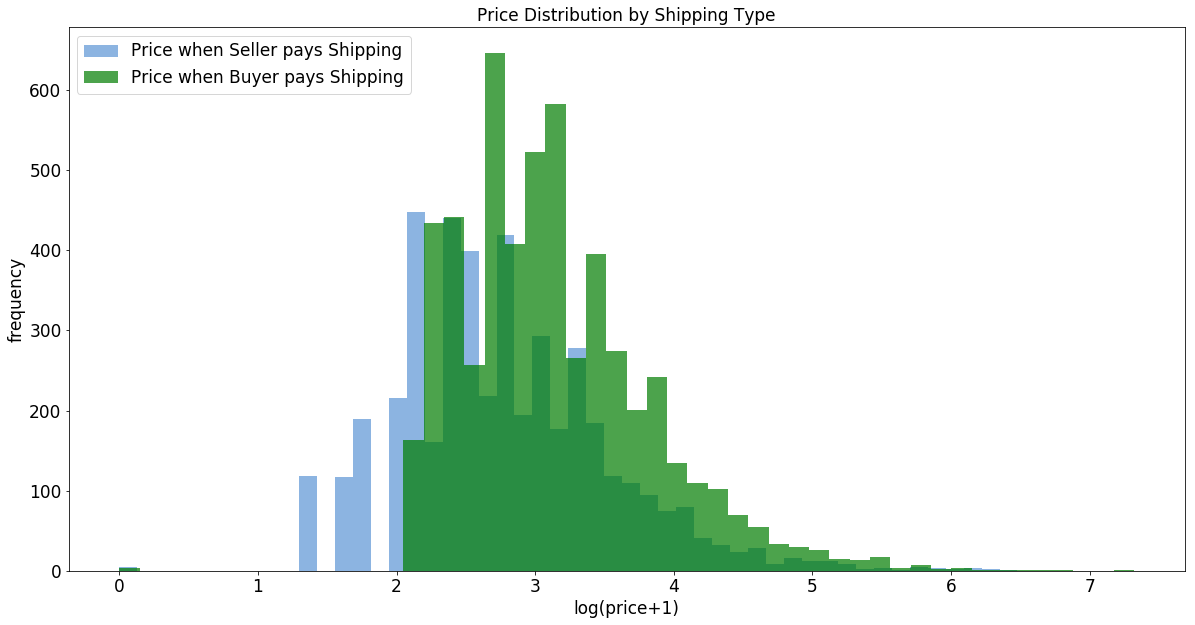

In [10]:
fig ,ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipByseller+1),color='#8CB4E1',alpha=1.0,bins=50,
        label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1),color='#007D00',alpha=0.7,bins=50,
        label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison',ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)',fontsize=17)
plt.ylabel('frequency',fontsize=17)
plt.title('Price Distribution by Shipping Type',fontsize=17)
plt.tick_params(labelsize=17)
plt.legend(loc='upper left',fontsize=17)
plt.show()

In [11]:
print("There are {0} unique values in the category columns".format(train.category_name.nunique()))

There are 626 unique values in the category columns


In [12]:
#カテゴリー種類のTop 5
train.category_name.value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    396
Women/Tops & Blouses/T-Shirts                     294
Beauty/Makeup/Face                                271
Beauty/Makeup/Lips                                227
Beauty/Makeup/Eyes                                185
Name: category_name, dtype: int64

In [13]:
#missing categories（欠損値）
print('There are {0} items that do not have a label'.format(train.category_name.isnull().sum()))

There are 47 items that do not have a label


In [14]:
#category_nameを分割する
def split_cat(text):
    #欠損値があるのでtyr文を利用
    try: return text.split('/')
    except: return('No label','No label', 'No label')

In [15]:
#分割したカテゴリーを新しく特徴量として追加
#*は行列の転置
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  general_cat  \
0         1                                 No description yet          Men   
1         0  This keyboard is in great condition and works ...  Electronics   
2         1  Adorable top with a hint of lace and a key hol...        Women   
3         1  New with tags. Leather horses. Retail for [rm]...         Home   
4         0          Complete with certificate of authenticity        Women   

              subcat_1            subcat_2  
0                 Tops            T-shirts  
1  Computers & Tablets  Components & Parts  
2       Tops & Blouses              Blouse  
3           Home Décor  Home Décor Accents  
4              Jewelry           Necklaces

In [16]:
#repeat the same step for the test set
#検証データにも実施
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [17]:
#カテゴリーの大分類の種類の数
print('There are {0} unique first sub-categories'.format(train.subcat_1.nunique()))

There are 106 unique first sub-categories


In [18]:
#カテゴリーの中分類の種類の数
print('There are {0} unique second sub-categories'.format(train.subcat_2.nunique()))

There are 478 unique second sub-categories


In [19]:
#カテゴリーの一意のデータ取得
x = train.general_cat.value_counts().index.values.astype('str')
#対応するデータ数
y = train.general_cat.value_counts().values
#カテゴリ毎のデータ数比率の計算
pct = [('{:.2f}'.format(v*100))+'%' for v in (y/float(len(train)))]

In [20]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout=layout)
plotly.offline.iplot(fig)

In [21]:
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_1'].value_counts().values[:15]
pct = [('%.2f'%(v*100))+'%'for v in (y/float(len(train)))][:15]

In [22]:
trace1 = go.Bar(x=x,y=y,text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale=False
                ))
layout = dict(title='Number of Items by SubCategory(Top 15)',
              yaxis=dict(title='Count'),
              xaxis=dict(title='SubCategory'))
fig=dict(data=[trace1],layout=layout)
plotly.offline.iplot(fig)

In [23]:
general_cats = train['general_cat'].unique()
x = [train.loc[train['general_cat']==cat,'price'] for cat in general_cats]

In [24]:
data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(general_cats))]

In [25]:
layout=dict(title='Price Distribution by General Category',
            yaxis=dict(title='Frequence'),
            xaxis=dict(title='Category'))
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig)

正規表現について
http://uxmilk.jp/41416

In [26]:
import re
import string
from sklearn.feature_extraction import stop_words

#記述に中に含まれる単語数をカウントする。ただし、ストップワードや数字、3文字以内の単語は含まない。
def wordCount(text):
    try:        
        #小文字に変換
        text = text.lower()
        #正規表現オブジェクトに変換
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        #regexに含まれる文字がtextにあった場合" "に変換する。
        txt = regex.sub(' ',text)
        #stopwordsに含まれず、かつ、3文字以上の場合
        words = [w for w in txt.split(' ') \
                if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except:
        return 0

stringには、文字列に関係した変数や関数が含まれている。主に、
- 特定のグループの文字列をまとめた変数
- 文字列をフォーマットする関数
の2つが入っている。

https://www.lifewithpython.com/2013/04/string.html

In [27]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [28]:
#re moduleで使えるようにエスケープする。
re.escape(string.punctuation)

'\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^\\_\\`\\{\\|\\}\\~'

In [29]:
train['desc_len'] = train['item_description'].apply(lambda x:wordCount(x))

In [30]:
test['desc_len'] = test['item_description'].apply(lambda x:wordCount(x))

In [31]:
train.head()

train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   
3         3                Leather Horse Statues                  1   
4         4                 24K GOLD plated rose                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   
3                 Home/Home Décor/Home Décor Accents        NaN   35.0   
4                            Women/Jewelry/Necklaces        NaN   44.0   

   shipping                                   item_description  general_cat  \
0         1                                 No description yet          Men   
1         0  This keyboard is in great condition and works ...  Electronics   
2         1  Adorable top with a hint of lace and a key hol...        Women   
3         1  New with tags. Leather horses. Retail for [rm]...         Home   
4         0          Complete with certificate of authenticity        Women   

              subcat_1            subcat_2  desc_len  
0                 Tops            T-shirts         1  
1  Computers & Tablets  Components & Parts        14  
2       Tops & Blouses              Blouse         8  
3           Home Décor  Home Décor Accents        14  
4              Jewelry           Necklaces         3

In [32]:
#文字数のプロット
trace1 = go.Histogram(x=np.log(train.desc_len+1))
fig=dict(data=[trace1])
plotly.offline.iplot(fig)

In [33]:
#文字数と価格の関係
df = train.groupby('desc_len')['price'].mean().reset_index()

In [34]:
trace1 = go.Scatter(x=df['desc_len'],
                    y=np.log(df['price']+1),
                    mode='lines+markers',
                    name='lines+markers')
layout = dict(title='Average Log(Price) by description Length',
              yaxis=dict(title='Average Log(Price)'),
              xaxis=dict(title='Description Length'))
fig=dict(data=[trace1],layout=layout)
plotly.offline.iplot(fig)

In [35]:
#descriptionが欠損値の数
train.item_description.isnull().sum()

0

In [36]:
#descriptionが欠損しているデータを削除
train = train[pd.notnull(train.item_description)]

tokenizeを行う
- 記述(description)を文章に分割し、文章をトークンに分割する。
- 句動点とストップワードを除外する。
- 小文字に変換する
- 3文字位上の単語に限定する。

In [37]:
import nltk
from nltk.corpus import stopwords

http://www.nltk.org/api/nltk.tokenize.html

In [38]:
from nltk.tokenize import sent_tokenize, word_tokenize
stop = set(stopwords.words('english'))
def tokenize(text):
    
    try:
        regex = re.compile('[' +re.escape(string.punctuation)+'0-9\\r\\t\\n]')
        text = regex.sub(' ',text) #remove punctuation and, space, number
        #文章毎の単語のリストの作成
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            #文章ごとの単語リストを統合
            tokens += token_by_sent
        #stopwordsに含まれないものだけ抽出
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        #数値を除く
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        #文字数が3文字以上に限定
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
    
    except TypeError as e: print(test,e)

In [39]:
#apply the tokenizer into the item description column
train['tokens'] = train.item_description.map(tokenize)
test['tokens'] = test.item_description.map(tokenize)

In [40]:
for description, tokens in zip(train.item_description.head(),
                              train.tokens.head()):
    print('description:',description)
    print('tokens:',tokens)
    print()

('description:', 'No description yet')
('tokens:', ['description', 'yet'])
()
('description:', 'This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.')
('tokens:', ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app'])
()
('description:', 'Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!')
('tokens:', ['adorable', 'top', 'hint', 'lace', 'key', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white'])
()
('description:', 'New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage')
('tokens:', ['new', 'tags', 'leather', 'horses', 'retail', 'stand', 'f

In [41]:
set(train.general_cat)

{'Beauty',
 'Electronics',
 'Handmade',
 'Home',
 'Kids',
 'Men',
 'No label',
 'Other',
 'Sports & Outdoors',
 'Vintage & Collectibles',
 'Women'}

In [42]:
from collections import Counter
#build dictionary with key=category and values as all the descriptions related
cat_desc = dict()
for cat in set(train.general_cat):
    #あるカテゴリーに属する記述を一つにまとめる
    text = ' '.join(train.loc[train.general_cat==cat,'item_description'].values)
    #あるカテゴリーの単語を保存する
    cat_desc [cat] = tokenize(text)
    
#find the most common words for the top 4 categories
women100 = Counter(cat_desc['Women']).most_common(100)
beauty100 = Counter(cat_desc['Beauty']).most_common(100)
kids100 = Counter(cat_desc['Kids']).most_common(100)
electronics100 = Counter(cat_desc['Electronics']).most_common(100)

In [43]:
from wordcloud import WordCloud

def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50,max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud

Text(0.5,1,'Electronics Top 100')

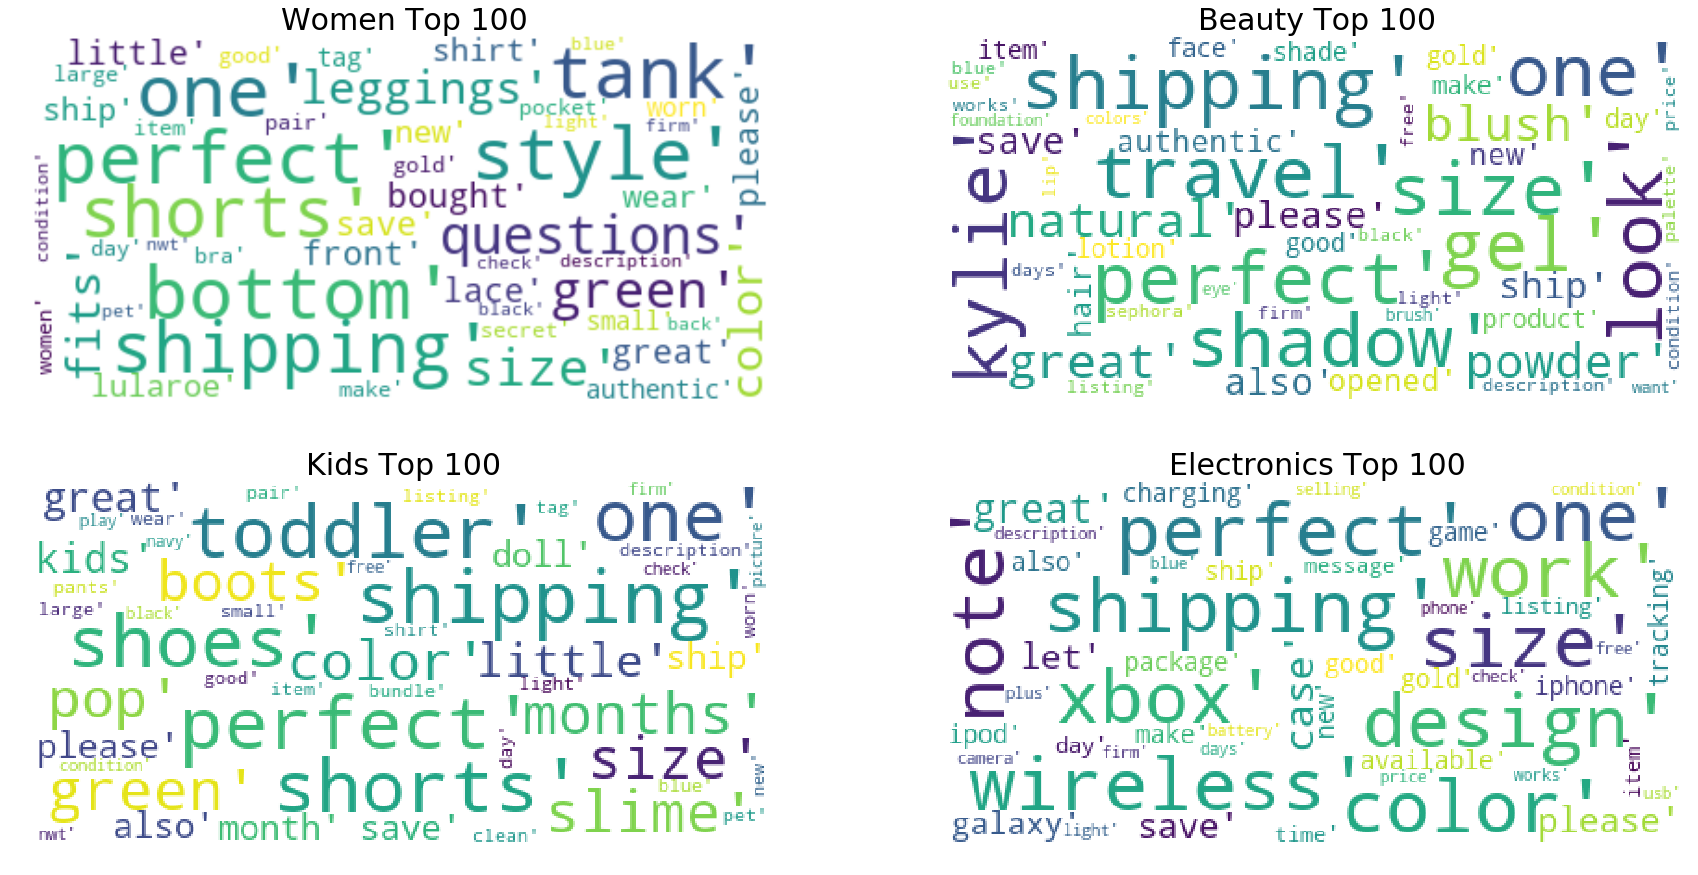

In [44]:
fig, axes = plt.subplots(2,2,figsize=(30,15))

ax = axes[0,0]
ax.imshow(generate_wordcloud(women100),interpolation='bilinear')
ax.axis('off')
ax.set_title('Women Top 100',fontsize=30)

ax = axes[0,1]
ax.imshow(generate_wordcloud(beauty100))
ax.axis('off')
ax.set_title('Beauty Top 100',fontsize=30)

ax = axes[1,0]
ax.imshow(generate_wordcloud(kids100))
ax.axis('off')
ax.set_title('Kids Top 100',fontsize=30)

ax = axes[1,1]
ax.imshow(generate_wordcloud(electronics100))
ax.axis('off')
ax.set_title('Electronics Top 100',fontsize=30)

## Pre-processing:tf-idf

文章またはコーパスの集合の語彙に関連して、特定の単語の重要性を定量化する。メトリックは2つの要素に依存します。

- term frequency:所定の文書内の単語の出現頻度
- Inverse Document Frequency:文書のコーパス内で単語が発生する回数の逆数。いくつもの文書で横断的に使われている単語はそんなに重要じゃない!を測る指標

https://takuti.me/note/tf-idf/

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,#単語の最低出現回数
                             max_features=1000,#特徴量（単語）の個数
                             tokenizer=tokenize,#トークナイザーの指定、さっき作ったやつ
                             ngram_range=(1,2))#n-gramの指定

In [46]:
all_desc = np.append(train.item_description.values,test.item_description.values)
#tfidf行列の作成。横軸は単語、縦軸はデータ
vz = vectorizer.fit_transform(list(all_desc))

In [47]:
# create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(),vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf),orient='index')
tfidf.columns = ['tfidf']

In [48]:
tfidf.sort_values(by='tfidf',ascending=True).head(10)

tfidf
new        2.164321
size       2.332614
brand      2.736753
condition  2.825470
brand new  2.844894
free       2.916693
shipping   3.065589
worn       3.132892
used       3.150343
never      3.275020

In [49]:
tfidf.sort_values(by='tfidf',ascending=False).head(10)

tfidf
henna      8.013166
teeth      7.536242
note note  7.348189
wax        7.239976
mailers    7.165868
labels     7.142337
brow       7.119348
tempered   7.119348
yeti       7.119348
soap       7.032337

特徴量が多すぎるのでSingular Value Decomposition を使って次元縮約する。そしてt-SNEを使ってさらなる次元縮約を実行する。t-SNEはすごく複雑で、次元が多すぎると計算に時間が掛かり過ぎるようです。一段回目に違った手法で次元縮約をしておくことを推奨している。

t-SNEについて
https://qiita.com/stfate/items/8988d01aad9596f9d586

svdについて
https://qiita.com/horiem/items/71380db4b659fb9307b4

In [50]:
trn = train.copy()
tst = test.copy()
trn['is_train'] = 1
tst['is_train'] = 0

sample_sz = 1500

combined_df = pd.concat([trn,tst])
combined_sample = combined_df.sample(n=sample_sz) #サンプルの抽出
vz_sample = vectorizer.fit_transform(list(combined_sample['item_description']))

In [51]:
from sklearn.decomposition import TruncatedSVD

n_comp = 30　#縮約後の次元数
svd = TruncatedSVD(n_components=n_comp,random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

In [52]:
#30に次元縮約できた
svd_tfidf.shape

(1500, 30)

In [53]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2,verbose=1,random_state=42,n_iter=1500)#verboseを1にすると一定の間隔でログを吐き出す

In [54]:
#t-SNEを適用
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.239s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.603065
[t-SNE] Error after 1500 iterations: 1.015587


In [55]:
#次元を2に縮約した
tsne_tfidf.shape

(1500, 2)

In [56]:
combined_sample.head(2)

brand_name                           category_name  desc_len general_cat  \
6566        NaN      Kids/Toys/Action Figures & Statues        57        Kids   
1732        NaN  Other/Daily & Travel items/Health Care        14       Other   

      is_train  item_condition_id  \
6566         0                  1   
1732         1                  1   

                                       item_description  \
6566  ThinkGeek Minecraft Wall Torch Pack of 2 Think...   
1732  Check out my other listings... I have iPhone, ...   

                                          name  price  shipping  \
6566  ThinkGeek Minecraft Wall Torch Pack of 2    NaN         1   
1732        48 hour SALE on all Essential oils   14.0         0   

                  subcat_1                  subcat_2  test_id  \
6566                  Toys  Action Figures & Statues   6566.0   
1732  Daily & Travel items               Health Care      NaN   

                                                 tokens  train_id  
6566  [thinkgeek, minecraft, wall, torch, pack, thin...       NaN  
1732  [check, listings, iphone, ipad, apple, watch, ...    1732.0

In [81]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600,
                       title='tf-idf clustering of the item description',
                       tools='pan,wheel_zoom,box_zoom,reset,hover,previewsave',
                       x_axis_type=None, y_axis_type=None, min_border=1)

Loading BokehJS ...

In [82]:
combined_sample.reset_index(inplace=True,drop=True)

In [83]:
tfidf_df = pd.DataFrame(tsne_tfidf,columns=['x','y'])
tfidf_df['description'] = combined_sample.item_description
tfidf_df['tokens'] = combined_sample.tokens
tfidf_df['category'] = combined_sample.general_cat

In [86]:
plot_tfidf.scatter(x='x', y='y', source=tfidf_df, alpha=0.7)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description":"@description", "tokens":"@tokens", "category":"@category"}
show(plot_tfidf)

UnicodeDecodeError: 'utf8' codec can't decode byte 0xc3 in position 2: unexpected end of data

## K-Means Clustering

In [87]:
from sklearn.cluster import MiniBatchKMeans
num_clusters = 30
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               n_init=1,
                               init_size=1000,batch_size=1000,verbose=0,max_iter=1000)

In [88]:
#全文章に対して作成したtfidf vectorizerに対してkmeans法を適用
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

In [101]:
#kmeansは生データに対して行う
#repeat the same steps for the sample
kmeans = kmeans_model.fit(vz_sample)
kmeans_clusters = kmeans.predict(vz_sample)
kmeans_distances = kmeans.transform(vz_sample)
#reduce dimension to 2 using tsne
#kmeans_distanceは30次元でこれを2次元にする。
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.003s...
[t-SNE] Computed neighbors for 1500 samples in 0.231s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.162415
[t-SNE] Error after 1500 iterations: 0.847264


In [102]:
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x','y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['description'] = combined_sample['item_description']
kmeans_df['category'] = combined_sample['general_cat']

In [104]:
plot_kmeans = bp.figure(plot_width=700,plot_height=600,
                        title='KMeans clustering of the description',
                        tools='pan,wheel_zoom,box_zoom,reset,hover,previewsave',
                        x_axis_type=None,y_axis_type=None,min_border=1)

In [105]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

In [108]:
source = ColumnDataSource(data=dict(x=kmeans_df['x'],y=kmeans_df['y'],
                                    color=colormap[kmeans_clusters],
                                    description=kmeans_df['description'],
                                    category=kmeans_df['category'],
                                    cluster=kmeans_df['cluster']))

plot_kmeans.scatter(x='x',y='y',color='color',source=source)
hover=plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category": "@category", "cluster":"@cluster"}
show(plot_kmeans)

## Latent Dirichlet Allocation

https://medium.com/intuitionmachine/the-two-paths-from-natural-language-processing-to-artificial-intelligence-d5384ddbfc18

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
cvectorizer = CountVectorizer(min_df=4,
                              max_features=1000,
                              tokenizer=tokenize,
                              ngram_range=(1,2))

In [110]:
cvz = cvectorizer.fit_transform(combined_sample['item_description'])

In [111]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_topics=20,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)

In [112]:
X_topics = lda_model.fit_transform(cvz)

/home/kyohei/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning:

n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21



In [113]:
n_top_words = 10
topic_summaries = []

topic_word = lda_model.components_ #get the topic word
vocab = cvectorizer.get_feature_names() #count vectorizerでの特徴量（言葉）

for i,topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i,'|'.join(topic_words)))

Topic 0: soft|light|super|lip|love|oil|mint|comfy|ready|super soft
Topic 1: new|shipping|free|size|free shipping|price|firm|brand|price firm|worn
Topic 2: box|iphone|case|plus|comes|phone|new box|apple|watch|quality
Topic 3: size|home|smoke|free|black|small|free home|smoke free|pet|worn
Topic 4: gold|size|large|fit|white|beautiful|print|size large|fits|dress
Topic 5: full|palette|lipstick|matte|color|body|makeup|liquid|colors|dry
Topic 6: new|brand|brand new|authentic|tags|size|new tags|skin|tag|still
Topic 7: one|great|condition|worn|great condition|sleeve|long|size|small|shirt
Topic 8: care|maroon|taken|euc|well|closure|tears|selling|swatched|case
Topic 9: used|times|gently|amazing|gently used|used times|anymore|book|several|shimmer
Topic 10: size|excellent|condition|excellent condition|nwt|one|women|lace|lotion|condition size
Topic 11: description|yet|description yet|cute|bag|super cute|super|leather|light|pocket
Topic 12: used|never|never used|perfect|perfect condition|new never|co

In [114]:
# reduce dimension to 2 using tsne
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.006s...
[t-SNE] Computed neighbors for 1500 samples in 0.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.400963
[t-SNE] Error after 1500 iterations: 0.888565


In [115]:
unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)

lda_keys = []
for i, tweet in enumerate(combined_sample['item_description']):
    lda_keys += [doc_topic[i].argmax()] #一番大きいトピックのラベルを選択

lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['description'] = combined_sample['item_description']
lda_df['category'] = combined_sample['general_cat']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

In [117]:
plot_lda = bp.figure(plot_width=700,
                     plot_height=600,
                     title='LDA topic visualization',
                     tools='pan,wheel_zoom,box_zoom,reset,previewsave',
                     x_axis_type=None,y_axis_type=None,min_border=1)

In [121]:
source = ColumnDataSource(data=dict(x=lda_df['x'],y=lda_df['y'],
                                    color=colormap[lda_keys],
                                    description=lda_df['description'],
                                    topic=lda_df['topic'],
                                    category=lda_df['category']))

plot_lda.scatter(source=source,x='x',y='y',color='color')
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={'description':'@description','topic':'@topic','category':'@category'}
show(plot_lda)